# EAT: Tuned with Knowledge

EECS 595 Final Project, Task 3: EAT

Credit: Ziqiao Ma

Last update: 2020.12.10

# Setup

## Colab setups

Run this cell load the autoreload extension.

In [ ]:
%load_ext autoreload
%autoreload 2

Run the following cell to mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Fill in the Google Drive path where you uploaded the file.

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/eecs595/eat'

Test if script files are located.

In [ ]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

['eat-baseline.ipynb', 'eat-reference.ipynb', 'eat-tuned.ipynb']


Check if dataset file is located, you should see `eat_test_unlabeled.json` and `eat_train.json` in the folder.

In [ ]:
!ls /content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/EAT

eat_test_unlabeled.json  eat_train.json


## Dependency installation

In [ ]:
import json
import codecs
import pandas as pd

import argparse
from copy import deepcopy
from tqdm import tqdm, trange

import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from keras.preprocessing.sequence import pad_sequences

Install `sentencepiece` for `XLNetTokenizer`

In [ ]:
!pip install sentencepiece

import sentencepiece

Install `transformers`

In [ ]:
!pip install transformers
# !pip install transformers==2.0.0

from transformers import BertModel, RobertaModel
from transformers import (AdamW, get_linear_schedule_with_warmup, AutoModelForQuestionAnswering,
                          BertConfig, BertForSequenceClassification, BertTokenizer,
                          XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          GPT2Config, GPT2ForSequenceClassification, GPT2Tokenizer)

Install `sentence-transformers` for [Sentence Bert](https://arxiv.org/abs/1908.10084) [1].

In [ ]:
# !pip install -U sentence-transformers
# from sentence_transformers import SentenceTransformer

## Helper Functions

In [ ]:
SEED = 0
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def select_field(feature_list, field_name):
    return [
        [choice[field_name] for choice in feature.choices_features]
        for feature in feature_list
    ]


def load_model(model='all'):
    if model == 'bert':
        return BertConfig, BertForSequenceClassification, BertTokenizer
    elif model == 'xlnet':
        return XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer
    elif model == 'roberta':
        return RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer
    elif model == 'gpt2':
        raise NotImplemented
        # return GPT2Config, AutoModelForQuestionAnswering, GPT2Tokenizer
    raise NotImplemented


def load_optimizer(args, model, train_size, learning_rate):
    num_training_steps = train_size * args.num_train_epochs
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters()
                    if not any(nd in n for nd in no_decay)],
         'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters()
                    if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]

    optimizer = AdamW(
        optimizer_grouped_parameters, lr=learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=num_training_steps)

    return model, optimizer, scheduler


def freeze(model, model_name):
    if model_name == 'bert':
        for param in model.bert.parameters():
            param.requires_grad = False
    elif model_name == 'xlnet':
        for param in model.xlnet.parameters():
            param.requires_grad = False
    elif model_name == 'roberta':
        for param in model.roberta.parameters():
            param.requires_grad = False
    elif model_name == 'gpt2':
        for param in model.gpt2.parameters():
            param.requires_grad = False
    return model


def get_accuracy(preds, labels, lengths=None, inspect=60):
    if inspect:
        print('\nThe first {} predictions'.format(inspect), preds[0:inspect])
    if lengths is None:
        return (preds == labels).mean()

    i, correct = 0, 0
    for n in lengths:
        pred, label = 1, 1
        for p in preds[i:i + n]:
            pred *= p
        for l in labels[i:i + n]:
            label *= l
        if pred == label:
            correct += 1
        i += n
    return correct / len(lengths)

# Benchmark

## Task Dataset

EAT (Everyday Actions in Text) is from the SLED (Situated Language and Embodied Dialogue) group created by Shane Storks. The dataset is in the form of a story of 5 sequential events represented by natural language texts $\{t_1,t_2,\cdots,t_5\}$ respectively. The model aims to identify whether the story is plausible using common sense reasoning and specify at which event the story becomes implausible, if any. Such plausible inference requires the model to have a strong background knowledge and a comprehensive ability to perform common sense reasoning and causal reasoning, since whether an event is plausible in the story is high dependent on the previous events.

In [ ]:
def load_data(dataset='commonsense_qa', preview=-1):

    assert dataset in {'commonsense_qa', 'conv_entail', 'eat'}

    if dataset == 'commonsense_qa':
        ds = load_dataset('commonsense_qa')

        if preview > 0:
            print('\nLoading an example...')
            data_tr = ds.data['train']
            question = data_tr['question']
            choices = data_tr['choices']
            answerKey = data_tr['answerKey']
            print(question[preview])
            for label, text in zip(choices[preview]['label'], choices[preview]['text']):
                print(label, text)
            print('Ans:', answerKey[preview])

    elif dataset == 'conv_entail':
        dev_file = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/Conversational_Entailment/dev_set.json'
        act_file = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/Conversational_Entailment/act_tag.json'
        dev_set = codecs.open(dev_file, 'r', encoding='utf-8').read()
        act_tag = codecs.open(act_file, 'r', encoding='utf-8').read()
        ds = json.loads(dev_set), json.loads(act_tag)

        if preview > 0:
            print('Preview not yet implemented for this dataset.')

    else:
        file_name = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/EAT/eat_train.json'
        eat = codecs.open(file_name, 'r', encoding='utf-8').read()
        ds = json.loads(eat)

        if preview > 0:
            print('\nLoading an example...')
            story = ds[preview]['story']
            label = ds[preview]['label']
            bp = ds[preview]['breakpoint']
            for line in story:
                print(line)
            print(label)
            print(bp)

    return ds


def load_data_frame(preview=True):
    
    file_name = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/EAT/eat_train.json'
    df = pd.read_json(file_name)
    
    if preview:
        print(df.head())
        print(len(df))

    return df

Run the following code to preview the dataset:

In [ ]:
ds = load_data(dataset='eat', preview=5)
print('\nDataset size:', len(ds))
df = load_data_frame()


Loading an example...
John grabbed the ladder and put it in his truck.
John put a drill and rope in the bucket and also put that in this truck.
John drove the bicycle to the neighbor's house.
John picked up a few other things and put them near the bucket in the truck.
John drove his truck to a neighbor's house to help them repair their storm-damaged shed.
0
3

Dataset size: 1044
                                               story  ...       id
0  [Tom took out the cooked meat., Tom took out t...  ...  train_0
1  [John went to the bathroom., John decided to t...  ...  train_1
2  [Ann drank from her water bottle., Ann decided...  ...  train_2
3  [Tom put on his shoes., Tom packed a suitcase....  ...  train_3
4  [Ann sat down on the couch., Ann reached for t...  ...  train_4

[5 rows x 4 columns]
1044


Get the length of all the messages in the train set to choose appropriate a padding length.

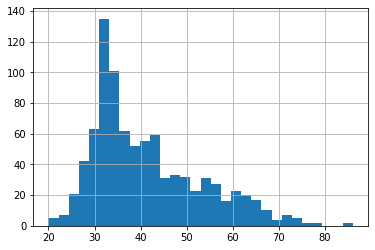

In [ ]:
df = load_data_frame(preview=False)
df['text'] = df['story'].apply(lambda x: ' '.join(x).lower())
train_text, val_text, train_labels, val_labels = train_test_split(
    df['text'], df['label'], random_state=SEED, test_size=0.15, stratify=df['label'])
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

### Data Preprocessing

In [ ]:
MAXLENGTH = 120

def embed(df):
    sent_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
    embedding = df['story'].apply(lambda x: sent_model.encode(x, convert_to_tensor=True, device=device))
    return embedding


class EATProcessor():
    def __init__(self, tokenizer, args=None):

        test_size = 0.15
        if args is not None:
            test_size = args.test_size

        self.tokenizer = tokenizer
        self.double_sep = 'roberta' in tokenizer.name_or_path
        self.cls_token = tokenizer.cls_token
        self.sep_token = tokenizer.sep_token

        df = load_data_frame(preview=False)
        self.train_story, self.val_story, self.train_bp, self.val_bp = train_test_split(
            df['story'], df['breakpoint'], random_state=SEED, test_size=test_size, stratify=df['breakpoint'])
        
    def truncate_seq_pair(self, token_a, token_b, max_len=MAXLENGTH-3):
        """
        Truncates a sequence pair in place to the maximum length.

        This is a simple heuristic which will always truncate the longer sequence one token at a time.
        This makes more sense than truncating an equal percent of tokens from each,
        since if one sequence is very short then each token that's truncated
        likely contains more information than a longer sequence.

        However, since we'd better not to remove tokens of options and questions,
        you can choose to use a bigger length or only pop from context
        """

        while True:
            total_length = len(token_a) + len(token_b)
            if total_length <= max_len:
                break
            if len(token_a) > len(token_b):
                token_a.pop()
            else:
                warning = 'Attention! you are removing from token_b (swag task is ok). ' \
                          'If you are training ARC and RACE (you are popping question + options), ' \
                          'you need to try to use a bigger max seq length!'
                print(warning)
                token_b.pop()

    def tokenize_and_encode(self, prev, next, max_len=MAXLENGTH):
        """
        Tokenize all of the sentences and map the tokens to their word IDs.
        Max is 512 if using BERT-based models, higher for longformer (2000+)
        """

        num_seps = 1
        extra_tokens = 3
        if self.double_sep:
            num_seps += 1
            extra_tokens += 1

        token_a = self.tokenizer.tokenize(prev)
        token_b = self.tokenizer.tokenize(next)
        self.truncate_seq_pair(token_a, token_b, max_len-extra_tokens)

        token_a = [self.cls_token] + token_a + ([self.sep_token] * num_seps)
        token_type_ids = [0] * len(token_a)
        token_b = token_b + [self.sep_token]
        token_type_ids += [1] * len(token_b)
        tokens = token_a + token_b

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        mask = [1] * len(input_ids)

        padding_length = max_len - len(input_ids)
        input_ids += ([0] * padding_length)
        mask += ([0] * padding_length)
        token_type_ids += ([0] * padding_length)

        assert len(input_ids) == max_len
        assert len(token_type_ids) == max_len
        assert len(mask) == max_len
            
        return input_ids, token_type_ids, mask

    def load_features(self, split='train'):

        if split == 'train':
            stories, bps = self.train_story, self.train_bp
        else:
            stories, bps = self.val_story, self.val_bp

        labels, seqs, segs, masks, lengths = [], [], [], [], []
        for story, breakpoint in zip(stories, bps):

            if breakpoint == -1:
                lengths.append(len(story)-1)
                for i in range(1, len(story)):
                    prev = ' '.join(story[:i])
                    next = story[i]
                    seq, seg, mask = self.tokenize_and_encode(prev, next)
                    seqs.append(seq)
                    segs.append(seg)
                    masks.append(mask)
                    labels.append(1)
            else:
                lengths.append(breakpoint)
                for i in range(1, breakpoint):
                    prev = ' '.join(story[:i])
                    next = story[i]
                    seq, seg, mask = self.tokenize_and_encode(prev, next)
                    seqs.append(seq)
                    segs.append(seg)
                    masks.append(mask)
                    labels.append(1)
                prev = ' '.join(story[:breakpoint])
                next = story[breakpoint]
                seq, seg, mask = self.tokenize_and_encode(prev, next)
                seqs.append(seq)
                segs.append(seg)
                masks.append(mask)
                labels.append(0)

        labels = torch.tensor(labels)
        seqs = torch.tensor(seqs)
        segs = torch.tensor(segs)
        masks = torch.tensor(masks)

        dataset = TensorDataset(seqs, masks, segs, labels)

        return dataset, lengths

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer_rbt = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

processor_tmp = EATProcessor(tokenizer_bert)
prev = 'John grabbed the ladder and put it in his truck.'
next = 'John put a drill and rope in the bucket and also put that in this truck.'
seq, seg, mask = processor_tmp.tokenize_and_encode(prev, next)
print(prev, next)
print(seq)
print(seg)
print(mask)
print(len(seq), len(seg), len(mask))

processor_tmp = EATProcessor(tokenizer_rbt)
prev = 'John grabbed the ladder and put it in his truck.'
next = 'John put a drill and rope in the bucket and also put that in this truck.'
seq, seg, mask = processor_tmp.tokenize_and_encode(prev, next)
print(prev, next)
print(seq)
print(seg)
print(mask)
print(len(seq), len(seg), len(mask))

John grabbed the ladder and put it in his truck. John put a drill and rope in the bucket and also put that in this truck.
[101, 2198, 4046, 1996, 10535, 1998, 2404, 2009, 1999, 2010, 4744, 1012, 102, 2198, 2404, 1037, 12913, 1998, 8164, 1999, 1996, 13610, 1998, 2036, 2404, 2008, 1999, 2023, 4744, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Knowledge Dataset

Situations with Adversarial Generations ([SWAG](https://rowanzellers.com/swag/)) from Zellers et al. is a benchmark dataset of about 113,000 beginnings of small texts each with four possible endings [2]. Given the context each text provides, systems decide which of the four endings is most plausible in
a task referred to as commonsense NLI.


In [ ]:
!wget https://raw.githubusercontent.com/rowanz/swagaf/master/data/train.csv
!mkdir swag/
!mv train.csv swag/train.csv

--2020-12-13 22:58:03--  https://raw.githubusercontent.com/rowanz/swagaf/master/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28243333 (27M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  26.93M  91.9MB/s    in 0.3s    

2020-12-13 22:58:04 (91.9 MB/s) - ‘train.csv’ saved [28243333/28243333]

mkdir: cannot create directory ‘swag/’: File exists


In [ ]:
def load_swag(preview=False):
    
    file_name = 'swag/train.csv'
    df = pd.read_csv(file_name)

    if preview:
        print(len(df))
        row = df.iloc[[preview]]
        print(row['sent1'][1])
        print(row['sent2'][1], '...')
        print(row['ending0'][1])
        print(row['ending1'][1])
        print(row['ending2'][1])
        print(row['ending3'][1])
        print(row['label'][1])
    return df

In [ ]:
df = load_swag(preview=1)

73546
A drum line passes by walking down the street playing their instruments.
Members of the procession ...
are playing ping pong and celebrating one left each in quick.
wait slowly towards the cadets.
continues to play as well along the crowd along with the band being interviewed.
continue to play marching, interspersed.
3


### Data Preprocessing

In [ ]:
class SWAGProcessor():
    """
    Load the processed SWAG dataset
    max(size) = 73546
    """
    def __init__(self, tokenizer, args=None):
        self.test_size = 0.15
        if args is not None:
            self.test_size = args.test_size

        self.tokenizer = tokenizer
        self.double_sep = 'roberta' in tokenizer.name_or_path
        self.cls_token = tokenizer.cls_token
        self.sep_token = tokenizer.sep_token

        self.df = load_swag()
    
    def truncate_seq_pair(self, token_a, token_b, max_len=MAXLENGTH-3):
        """
        Truncates a sequence pair in place to the maximum length.

        This is a simple heuristic which will always truncate the longer sequence one token at a time.
        This makes more sense than truncating an equal percent of tokens from each,
        since if one sequence is very short then each token that's truncated
        likely contains more information than a longer sequence.

        However, since we'd better not to remove tokens of options and questions,
        you can choose to use a bigger length or only pop from context
        """

        while True:
            total_length = len(token_a) + len(token_b)
            if total_length <= max_len:
                break
            if len(token_a) > len(token_b):
                token_a.pop()
            else:
                warning = 'Attention! you are removing from token_b (swag task is ok). ' \
                          'If you are training ARC and RACE (you are popping question + options), ' \
                          'you need to try to use a bigger max seq length!'
                print(warning)
                token_b.pop()

    def tokenize_and_encode(self, prev, next, max_len=MAXLENGTH):
        """
        Tokenize all of the sentences and map the tokens to their word IDs.
        Max is 512 if using BERT-based models, higher for longformer (2000+)
        """

        num_seps = 1
        extra_tokens = 3
        if self.double_sep:
            num_seps += 1
            extra_tokens += 1

        token_a = self.tokenizer.tokenize(prev)
        token_b = self.tokenizer.tokenize(next)
        self.truncate_seq_pair(token_a, token_b, max_len-extra_tokens)

        token_a = [self.cls_token] + token_a + ([self.sep_token] * num_seps)  
        token_type_ids = [0] * len(token_a)
        token_b = token_b + [self.sep_token]
        token_type_ids += [1] * len(token_b)
        tokens = token_a + token_b

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        mask = [1] * len(input_ids)

        padding_length = max_len - len(input_ids)
        input_ids += ([0] * padding_length)
        mask += ([0] * padding_length)
        token_type_ids += ([0] * padding_length)

        assert len(input_ids) == max_len
        assert len(token_type_ids) == max_len
        assert len(mask) == max_len
            
        return input_ids, token_type_ids, mask

    def load_features(self, size=73546, balanced=False):

        print("Creating features from dataset...")
        labels, seqs, segs, masks = [], [], [], []
        for row in df.iterrows():

            label = row[1]['label']
            start = row[1]['sent1']
            sent = row[1]['sent2']

            if balanced:
                ending = row[1]['ending{}'.format(label)]
                next = ' '.join([sent, ending]).lower()
                seq, seg, mask = self.tokenize_and_encode(start, next)
                seqs.append(seq)
                segs.append(seg)
                masks.append(mask)
                labels.append(1)
                ending = row[1]['ending{}'.format((label+1)%4)]
                next = ' '.join([sent, ending]).lower()
                seq, seg, mask = self.tokenize_and_encode(start, next)
                seqs.append(seq)
                segs.append(seg)
                masks.append(mask)
                labels.append(0)
            else:
                for i in range(3):
                    ending = row[1]['ending{}'.format(i)]
                    next = ' '.join([sent, ending]).lower()

                    seq, seg, mask = self.tokenize_and_encode(start, next)
                    seqs.append(seq)
                    segs.append(seg)
                    masks.append(mask)
                    if i == label:
                        labels.append(1)
                    else:
                        labels.append(0)
                        
            size -= 1
            if size == 0:
                break

        train_seq, val_seq, train_seg, val_seg, train_mask, val_mask, train_labels, val_labels = train_test_split(
            seqs, segs, masks, labels, random_state=SEED, test_size=self.test_size, stratify=labels)
        
        a = torch.tensor(train_seq)
        train_seq = torch.tensor(train_seq)
        val_seq = torch.tensor(val_seq)
        train_seg = torch.tensor(train_seg)
        val_seg = torch.tensor(val_seg)
        train_mask = torch.tensor(train_mask)
        val_mask = torch.tensor(val_mask)
        train_labels = torch.tensor(train_labels)
        train_y = torch.tensor(train_labels)
        val_y = torch.tensor(val_labels)

        train_data = TensorDataset(train_seq, train_mask, train_seg, train_y)
        val_data = TensorDataset(val_seq, val_mask, val_seg, val_y)

        return train_data, val_data


In [ ]:
processor_tmp_2 = SWAGProcessor(tokenizer_rbt)

prev = 'A drum line passes by walking down the street playing their instruments.'
next = 'Members of the procession are playing ping pong and celebrating one left each in quick.'
seq, seg, mask = processor_tmp_2.tokenize_and_encode(prev, next)
print(prev, next)
print(seq)
print(seg)
print(mask)
print(len(seq), len(seg), len(mask))

A drum line passes by walking down the street playing their instruments. Members of the procession are playing ping pong and celebrating one left each in quick.
[0, 250, 12638, 516, 3974, 30, 3051, 159, 5, 2014, 816, 49, 9571, 4, 2, 2, 31339, 9, 5, 21191, 32, 816, 36477, 181, 1657, 8, 6146, 65, 314, 349, 11, 2119, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

# Experiment

## Pre-trained Model

Self-designed model for flexibility.

In [ ]:
class MyBertClassifier(torch.nn.Module):

    def __init__(self, model_name='bert-base-uncased', num_labels=1, dropout_rate=0.2, freeze=False):
        super(MyBertClassifier, self).__init__()
        
        if num_labels == 1:
            self.loss_fct = torch.nn.BCEWithLogitsLoss()
        else:
            self.loss_fct = torch.nn.CrossEntropyLoss()
        self.bert = BertModel.from_pretrained(model_name)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(self.num_embed(model_name), 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, num_labels)

        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

    def num_embed(self, model_name):
        embedding_size = {
            'bert-base-uncased': 768,
            'bert-large-uncased': 1024
        }
        return embedding_size[model_name]

    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):

        out = self.bert(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        token_type_ids=token_type_ids)
        x = out.pooler_output
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        loss = None
        if labels is not None:
            # x = np.argmax(x, axis=1)
            loss = self.loss_fct(x.flatten(), labels.float())
        
        return loss, x


class MyRobertaClassifier(torch.nn.Module):

    def __init__(self, model_name='roberta-base', num_labels=2, dropout_rate=0.2, freeze=False):
        super(MyRobertaClassifier, self).__init__()
        
        if num_labels == 1:
            self.loss_fct = torch.nn.BCEWithLogitsLoss()
        else:
            self.loss_fct = torch.nn.CrossEntropyLoss()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(self.num_embed(model_name), 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, num_labels)

        if freeze:
            for param in self.roberta.parameters():
                param.requires_grad = False

    def num_embed(self, model_name):
        embedding_size = {
            'roberta-base': 768,
            'roberta-large': 1024,
        }
        return embedding_size[model_name]

    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):

        out = self.roberta(input_ids=input_ids, 
                           attention_mask=attention_mask, 
                           token_type_ids=None)
        x = out.pooler_output
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        loss = None
        if labels is not None:
            # x = np.argmax(x, axis=1)
            loss = self.loss_fct(x.flatten(), labels.float())
        
        return loss, x

## Runtime

Training and evaluation functions.

In [ ]:
def fine_tune(args, model, tokenizer):

    processor = SWAGProcessor(tokenizer, args)
    dataset_tr, dataset_val = processor.load_features(size=args.pretrain_size)

    print('\n Loading training dataset')
    sampler_tr = RandomSampler(dataset_tr)
    dataloader_tr = DataLoader(dataset_tr, sampler=sampler_tr, batch_size=args.batch_size)

    print('\n Loading validation dataset')
    sampler_val = SequentialSampler(dataset_val)
    dataloader_val = DataLoader(dataset_val, sampler=sampler_val, batch_size=args.batch_size)

    model, optimizer, scheduler = load_optimizer(args, model, len(dataloader_tr), args.learning_rate_tune)

    tr_loss = 0.00
    num_steps = 0

    model.train()
    train_iterator = trange(int(args.num_train_epochs), desc="Epoch", disable=False, leave=True, position=1)

    for _ in train_iterator:
        disable = False
        if len(dataloader_tr) > 1000:
            disable = True
        epoch_iterator = tqdm(dataloader_tr, desc="Iteration", disable=disable, leave=True, position=1)
        for step, batch in enumerate(epoch_iterator):

            model.train()

            batch = tuple(b.to(args.device) for b in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args.model_type in ['bert', 'xlnet'] else None,
                      'labels': batch[3]}

            model.zero_grad()
            outputs = model(**inputs)
            loss = outputs[0]

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            tr_loss += loss.item()

            optimizer.step()
            scheduler.step()
            
            num_steps += 1

            if args.logging_steps_tune > 0 and num_steps % args.logging_steps_tune == 0:
                results = evaluate(args, model, dataloader_val)
                print("\n val acc: {}, val loss: {}"
                      .format(str(results['val_acc']), str(results['val_loss'])))

    loss = tr_loss / num_steps

    return model


def train(args, model, tokenizer):
    train_epoch = 1
    
    processor = EATProcessor(tokenizer, args)
    dataset_tr, lengths_tr = processor.load_features(split='train')
    dataset_val, lengths_val = processor.load_features(split='val')

    print('\n Loading training dataset')
    sampler_tr = RandomSampler(dataset_tr)
    dataloader_tr = DataLoader(dataset_tr, sampler=sampler_tr, batch_size=args.batch_size)

    print('\n Loading validation dataset')
    sampler_val = SequentialSampler(dataset_val)
    dataloader_val = DataLoader(dataset_val, sampler=sampler_val, batch_size=args.batch_size)

    num_steps = 0
    best_steps = 0
    tr_loss = 0.0
    best_val_acc, best_val_loss = 0.0, 99999999999.0
    best_model = None

    _, optimizer, scheduler = load_optimizer(args, model, len(dataloader_tr), args.learning_rate)

    model.train()
    train_iterator = trange(int(train_epoch), desc="Epoch", disable=False, leave=True, position=1)

    for _ in train_iterator:

        epoch_iterator = tqdm(dataloader_tr, desc="Iteration", disable=False, leave=True, position=1)
        for step, batch in enumerate(epoch_iterator):

            batch = tuple(b.to(args.device) for b in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args.model_type in ['bert', 'xlnet'] else None,
                      'labels': batch[3]}
                      
            model.zero_grad()
            outputs = model(**inputs)
            loss = outputs[0]

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            tr_loss += loss.item()

            optimizer.step()
            scheduler.step()
            
            num_steps += 1

            if args.logging_steps > 0 and num_steps % args.logging_steps == 0:
                results = evaluate(args, model, dataloader_val, lengths_val)
                print("\n val acc: {}, val loss: {}"
                      .format(str(results['val_acc']), str(results['val_loss'])))
                if results["val_loss"] < best_val_loss:
                    best_val_acc, best_val_loss = results["val_acc"], results["val_loss"]
                    best_steps = num_steps
                    best_model = deepcopy(model)

    loss = tr_loss / num_steps
    results = evaluate(args, model, dataloader_tr, lengths_tr)
    print("\n Final train acc: {}, Final train loss: {}".format(str(results['val_acc']), str(results['val_loss'])))
    print("\n Best val acc: {}, Best val loss: {}".format(best_val_acc, best_val_loss))

    return best_model


def evaluate(args, model, dataloader, lengths=None):

    val_loss = 0.0
    num_steps = 0
    preds, labels = None, None

    results = {}

    for batch in tqdm(dataloader, desc="Validation", disable=True, leave=True, position=1):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args.model_type in ['bert', 'xlnet'] else None,
                      'labels': batch[3]}
            outputs = model(**inputs)
            loss, logits = outputs[:2]
 
            val_loss += loss.mean().item()

        num_steps += 1

        if preds is None:
            preds = logits.detach().cpu().numpy()
            labels = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            labels = np.append(labels, inputs['labels'].detach().cpu().numpy(), axis=0)

    loss = val_loss / num_steps
    preds = np.argmax(preds, axis=1)
    acc = get_accuracy(preds, labels, lengths)
    result = {"val_acc": acc, "val_loss": loss}
    results.update(result)
    
    # classification_report(labels, preds)

    return results


def test(args, tokenizer, model):

    processor = EATProcessor(tokenizer, args)
    dataset_val, lengths_val = processor.load_features(split='val')
    sampler_val = SequentialSampler(dataset_val)
    dataloader_val = DataLoader(dataset_val, sampler=sampler_val, batch_size=args.batch_size)
    results = evaluate(args, model, dataloader_val, lengths_val)
    print("\n Final val acc: {}, val loss: {}".format(str(results['val_acc']), str(results['val_loss'])))


In [ ]:
def main(args):

    print('Using device', args.device)
    print('Using model', args.model_type)
    set_seed(args.seed)

    num_labels = 2

    config_class, model_class, tokenizer_class = load_model(args.model_type)
    config = config_class.from_pretrained(
        args.config_name if args.config_name else args.model_name,
        num_labels=num_labels, finetuning_task=args.task_name)
    tokenizer = tokenizer_class.from_pretrained(
        args.tokenizer_name if args.tokenizer_name else args.model_name,
        do_lower_case=True)
    
    model = model_class.from_pretrained(args.model_name, config=config,
                                        from_tf=bool('.ckpt' in args.model_name))
    # model = MyBertClassifier(model_name=args.config_name, num_labels=1)
    
    model.to(args.device)

    print('\nTuning...')
    model = fine_tune(args, model, tokenizer)
    # model = freeze(model, args.model_name)

    print('\nTraining...')
    best_model = train(args, model, tokenizer)

    print('\nTesting...')
    test(args, tokenizer, best_model)

The default model is based on `bert`, and
```
parser.add_argument("--model_name", type=str, default='bert-base-uncased',
                    help="Path to pre-trained model or shortcut name. See https://huggingface.co/models")
```

This would leads to

```
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using custom data configuration default
```

Should check https://huggingface.co/models for other models.

Setup parameters.

In [ ]:
def run(model_type='bert',
        model_name='bert-base-uncased',
        task_name=None,
        batch_size=64,
        lr=1e-5,
        lr_tune=1e-5,
        epochs=1,
        pretrain_size=1000,
        logging_steps=50,
        logging_steps_tune=200):
  
    parser = argparse.ArgumentParser(description="Common sense question answering")
    parser.add_argument("--model_type", type=str, default=model_type,
                        help="Model: <str> [ bert | xlnet | roberta | gpt2 ]")
    parser.add_argument("--task_name", default=task_name, type=str, required=False,
                        help="The name of the task to train: <str> [ commonqa ]")
    parser.add_argument("--model_name", type=str,
                        default=model_name,
                        help="Path to pre-trained model or shortcut name."
                              "See https://huggingface.co/models")
    parser.add_argument("--config_name", type=str,
                        default=model_name,
                        help="Pre-trained config name or path")
    parser.add_argument("--tokenizer_name", default=model_name, type=str,
                        help="Pre-trained tokenizer name or path if not the same as model_name")

    parser.add_argument("--max_seq_length", default=100, type=int,
                        help="The maximum total input sequence length after tokenization. "
                                "Sequences longer than this will be truncated, sequences shorter will be padded.")
    parser.add_argument("--batch_size", default=batch_size, type=int,
                        help="Batch size for training.")

    parser.add_argument("--learning_rate", default=lr, type=float,
                        help="The initial learning rate for Adam.")
    parser.add_argument("--learning_rate_tune", default=lr_tune, type=float,
                        help="The initial learning rate for Adam.")
    parser.add_argument("--weight_decay", default=0.0, type=float,
                        help="Weight decay if we apply some.")
    parser.add_argument("--adam_epsilon", default=1e-8, type=float,
                        help="Epsilon for Adam optimizer.")
    parser.add_argument("--test_size", default=0.2, type=float,
                        help="The ratio of size of validation set")
    parser.add_argument("--pretrain_size", default=pretrain_size, type=float,
                        help="The ratio of size of validation set")
        
    parser.add_argument("--num_train_epochs", default=epochs, type=int,
                        help="Total number of training epochs to perform.")
    parser.add_argument("--warmup_steps", default=epochs//6, type=int,
                        help="Linear warmup over warmup_steps.")
    parser.add_argument('--logging_steps', type=int, default=logging_steps,
                        help="Log every n updates steps.")
    parser.add_argument('--logging_steps_tune', type=int, default=logging_steps_tune,
                        help="Log every n updates steps.")

    parser.add_argument('--fp16', type=bool, default=True,
                        help="Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit")
    parser.add_argument('--opt_level', type=str, default='O1',
                        help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                              "See details at https://nvidia.github.io/apex/amp.html")

    parser.add_argument("--seed", type=int, default=0, help="Random seed: <int>")
    parser.add_argument("--device", default=DEVICE)

    args, unknown = parser.parse_known_args()
    main(args)

## Finetuning

### Bert

In [ ]:
model_type = 'bert'
model_name = 'bert-base-uncased'
task_name = None
batch_size = 16
epochs = 6
lr_tune = 5e-5
lr = 5e-6
# pretrain_size = 73546
pretrain_size = 50000
logging_steps = 20
logging_steps_tune = 200

run(model_type, model_name, task_name, batch_size, lr, lr_tune, epochs, pretrain_size, logging_steps, logging_steps_tune)

In [ ]:
model_type = 'bert'
model_name = 'bert-large-uncased'
task_name = None
batch_size = 16
epochs = 1
lr_tune = 5e-5
lr = 1e-5
pretrain_size = 1000
logging_steps = 20
logging_steps_tune = 20

run(model_type, model_name, task_name, batch_size, lr, lr_tune, epochs, pretrain_size, logging_steps, logging_steps_tune)

Using device cuda
Using model bert


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


Tuning...
Creating features from dataset...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]


 Loading training dataset

 Loading validation dataset



Iteration:  13%|█▎        | 20/150 [00:41<13:36,  6.28s/it]


The first 60 predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 val acc: 0.7533333333333333, val loss: 0.5568474374319378



Iteration:  27%|██▋       | 40/150 [01:21<10:41,  5.83s/it]


The first 60 predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 val acc: 0.7533333333333333, val loss: 0.5193860609280435



Iteration:  40%|████      | 60/150 [02:01<09:01,  6.01s/it]


The first 60 predictions [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]

 val acc: 0.7533333333333333, val loss: 0.5125216653472499



Iteration:  53%|█████▎    | 80/150 [02:41<06:55,  5.93s/it]


The first 60 predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 val acc: 0.7533333333333333, val loss: 0.4998805687615746



Iteration:  67%|██████▋   | 100/150 [03:21<04:58,  5.97s/it]


The first 60 predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 val acc: 0.7566666666666667, val loss: 0.4823375281534697



Iteration:  80%|████████  | 120/150 [04:02<02:59,  5.97s/it]


The first 60 predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]

 val acc: 0.7666666666666667, val loss: 0.475768318301753



Iteration:  93%|█████████▎| 140/150 [04:42<00:59,  5.96s/it]


The first 60 predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]

 val acc: 0.775, val loss: 0.47159328821458313



Iteration: 100%|██████████| 150/150 [04:54<00:00,  1.97s/it]

Epoch: 100%|██████████| 1/1 [04:54<00:00, 294.97s/it]



Training...



Iteration:   0%|          | 0/188 [00:00<?, ?it/s]


 Loading training dataset

 Loading validation dataset



Iteration:  11%|█         | 20/188 [00:44<20:07,  7.19s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.4036301057389442



Iteration:  21%|██▏       | 40/188 [01:28<17:29,  7.09s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.3880135033358919



Iteration:  32%|███▏      | 60/188 [02:12<15:09,  7.11s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.36922383657161223



Iteration:  43%|████▎     | 80/188 [02:56<12:53,  7.16s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.3555502176601836



Iteration:  53%|█████▎    | 100/188 [03:40<10:23,  7.09s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.36857878274105965



Iteration:  64%|██████▍   | 120/188 [04:24<08:02,  7.09s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.3631977058471517



Iteration:  74%|███████▍  | 140/188 [05:08<05:43,  7.16s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.33660707052083727



Iteration:  85%|████████▌ | 160/188 [05:52<03:19,  7.11s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.34232060642952616



Iteration:  96%|█████████▌| 180/188 [06:36<00:56,  7.09s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.3334676631270571



Iteration: 100%|██████████| 188/188 [06:45<00:00,  2.16s/it]

Epoch: 100%|██████████| 1/1 [06:45<00:00, 405.98s/it]



The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 Final train acc: 0.5952095808383233, Final train loss: 0.2755654909192248

 Best val acc: 0.5023923444976076, Best val loss: 0.4036301057389442

Testing...

The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 Final val acc: 0.5023923444976076, val loss: 0.4036301057389442


In [ ]:
model_type = 'bert'
model_name = 'bert-large-uncased'
task_name = None
batch_size = 16
epochs = 6
lr_tune = 2e-5
lr = 5e-5
pretrain_size = 10000
logging_steps = 20
logging_steps_tune = 250

run(model_type, model_name, task_name, batch_size, lr, lr_tune, epochs, pretrain_size, logging_steps, logging_steps_tune)

Using device cuda
Using model bert


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


Tuning...
Creating features from dataset...
Attention! you are removing from token_b (swag task is ok). If you are training ARC and RACE (you are popping question + options), you need to try to use a bigger max seq length!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]


 Loading training dataset

 Loading validation dataset

The first 60 predictions [0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0]

 val acc: 0.7873333333333333, val loss: 0.4665636904637019

The first 60 predictions [0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0]

 val acc: 0.7711666666666667, val loss: 0.4830284248987834

The first 60 predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]

 val acc: 0.7585, val loss: 0.5132558157841365

The first 60 predictions [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 val acc: 0.802, val loss: 0.43396337485313413

The first 60 predictions [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 


Epoch:  17%|█▋        | 1/6 [45:00<3:45:01, 2700.24s/it]


The first 60 predictions [0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0]

 val acc: 0.8115, val loss: 0.40654739691813785

The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0]

 val acc: 0.8085, val loss: 0.47883103393514953

The first 60 predictions [0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1]

 val acc: 0.8111666666666667, val loss: 0.4395154359738032

The first 60 predictions [0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.78, val loss: 0.5365045765737693

The first 60 predictions [0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1]

 val acc: 0.7943333333333333, val loss: 0.46596071


Epoch:  33%|███▎      | 2/6 [1:30:22<3:00:27, 2706.86s/it]


The first 60 predictions [0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1]

 val acc: 0.81, val loss: 0.45635979073743027

The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1]

 val acc: 0.812, val loss: 0.8208587189440926

The first 60 predictions [0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1]

 val acc: 0.8163333333333334, val loss: 0.7430574367257456

The first 60 predictions [0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

 val acc: 0.8093333333333333, val loss: 0.705051413765798

The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1]

 val acc: 0.8076666666666666, val loss: 0


Epoch:  50%|█████     | 3/6 [2:16:27<2:16:13, 2724.43s/it]


The first 60 predictions [0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.8115, val loss: 0.5967149828622739

The first 60 predictions [0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1]

 val acc: 0.8183333333333334, val loss: 0.8917592056312909

The first 60 predictions [0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.8068333333333333, val loss: 0.9092960957655062

The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1]

 val acc: 0.8145, val loss: 0.7904912623874844

The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1]

 val acc: 0.8095, val loss: 0.82170880


Epoch:  67%|██████▋   | 4/6 [3:02:31<1:31:12, 2736.27s/it]


The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.8045, val loss: 0.8634140171011289

The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1]

 val acc: 0.8171666666666667, val loss: 0.9837861055405811

The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.8106666666666666, val loss: 1.0176312897861934

The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.8186666666666667, val loss: 0.986801527693402

The first 60 predictions [0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.8085, val loss:


Epoch:  83%|████████▎ | 5/6 [3:48:33<45:43, 2743.93s/it]  


The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.818, val loss: 0.9405725289539745

The first 60 predictions [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1]

 val acc: 0.8235, val loss: 1.0417789642479427

The first 60 predictions [0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.8171666666666667, val loss: 1.0261754489252344

The first 60 predictions [0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.8135, val loss: 1.0589251904667665

The first 60 predictions [0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.8145, val loss: 1.0767322651529685

The


Epoch: 100%|██████████| 6/6 [4:34:33<00:00, 2745.54s/it]


The first 60 predictions [0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1]

 val acc: 0.816, val loss: 1.082403503245907

Training...




Iteration:   0%|          | 0/188 [00:00<?, ?it/s]


 Loading training dataset

 Loading validation dataset



Iteration:  11%|█         | 20/188 [00:44<20:10,  7.21s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.4036297126019255



Iteration:  21%|██▏       | 40/188 [01:28<17:33,  7.11s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.4013578324241841



Iteration:  32%|███▏      | 60/188 [02:12<15:10,  7.11s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.4178283667944847



Iteration:  43%|████▎     | 80/188 [02:56<12:51,  7.14s/it]


The first 60 predictions [1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0
 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0]

 val acc: 0.5502392344497608, val loss: 0.5284035605319003



Iteration:  53%|█████▎    | 100/188 [03:40<10:26,  7.12s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.36831063412605447



Iteration:  64%|██████▍   | 120/188 [04:24<07:58,  7.04s/it]


The first 60 predictions [1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0]

 val acc: 0.5311004784688995, val loss: 0.42169642226493104



Iteration:  74%|███████▍  | 140/188 [05:08<05:40,  7.10s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5167464114832536, val loss: 0.35531742807398453



Iteration:  85%|████████▌ | 160/188 [05:52<03:18,  7.10s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.49760765550239233, val loss: 0.4459370517350258



Iteration:  96%|█████████▌| 180/188 [06:35<00:56,  7.08s/it]


The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 val acc: 0.5023923444976076, val loss: 0.40650987910463454



Iteration: 100%|██████████| 188/188 [06:45<00:00,  2.15s/it]

Epoch: 100%|██████████| 1/1 [06:45<00:00, 405.07s/it]



The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 Final train acc: 0.5976047904191617, Final train loss: 0.4078329834452969

 Best val acc: 0.5167464114832536, Best val loss: 0.35531742807398453

Testing...

The first 60 predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 Final val acc: 0.5167464114832536, val loss: 0.35531742807398453


In [ ]:
model_type = 'bert'
model_name = 'textattack/bert-base-uncased-MNLI'
task_name = 'mnli'
batch_size = 16
epochs = 1
lr_tune = 1e-4
lr = 1e-5
# pretrain_size = 73546
pretrain_size = 5
logging_steps = 20
logging_steps_tune = 50

run(model_type, model_name, task_name, batch_size, lr, lr_tune, epochs, pretrain_size, logging_steps, logging_steps_tune)

### XLNet

Remeber that `XLNet` pads from the left. Need to change the preprocessor!

In [ ]:
model_type = 'xlnet'
model_name = 'xlnet-base-cased'
task_name = None
batch_size = 16
epochs = 1
lr_tune = 1e-4
lr = 1e-5
pretrain_size = 70000
logging_steps = 10
logging_steps_tune = 1000

run(model_type, model_name, task_name, batch_size, lr, lr_tune, epochs, pretrain_size, logging_steps, logging_steps_tune)

### RoBerta

Check this for `</s>` rules: https://github.com/pytorch/fairseq/issues/1654

I may have got it wrong. Check `Data Preprocessing` sections.

In [ ]:
model_type = 'roberta'
model_name = 'roberta-base'
task_name = None
batch_size = 16
epochs = 1
lr_tune = 1e-5
lr = 2e-6
# pretrain_size = 73546
pretrain_size = 1000
logging_steps = 10
logging_steps_tune = 20

run(model_type, model_name, task_name, batch_size, lr, lr_tune, epochs, pretrain_size, logging_steps, logging_steps_tune)

In [ ]:
model_type = 'roberta'
model_name = 'roberta-large'
task_name = None
batch_size = 16
epochs = 1
lr_tune = 1e-6
lr = 5e-6
# pretrain_size = 73546
pretrain_size = 1000
logging_steps = 10
logging_steps_tune = 25

run(model_type, model_name, task_name, batch_size, lr, lr_tune, epochs, pretrain_size, logging_steps, logging_steps_tune)

Try `roberta-large-mnli`, but this one has a `neutral` label (`num_labels = 3`).

There is an [online entailment](https://huggingface.co/roberta-large-mnli?text=John+grabbed+the+ladder+and+put+it+in+his+truck.+%3C%2Fs%3E%3C%2Fs%3E+John+put+a+drill+and+rope+in+the+bucket+and+also+put+that+in+this+truck) model to play with.

In [ ]:
# Try roberta-large-mnli
model_type = 'roberta'
model_name = 'roberta-large-mnli'
task_name = 'mnli'
batch_size = 16
epochs = 1
lr_tune = 1e-6
lr = 5e-6
# pretrain_size = 73546
pretrain_size = 1000
logging_steps = 10
logging_steps_tune = 25

run(model_type, model_name, task_name, batch_size, lr, lr_tune, epochs, pretrain_size, logging_steps, logging_steps_tune)

# References

[1] Reimers, N., & Gurevych, I. (2019). Sentence-bert: Sentence embeddings using siamese bert-networks. arXiv preprint arXiv:1908.10084.

[2] Zellers, R., Bisk, Y., Schwartz, R., & Choi, Y. (2018). Swag: A large-scale adversarial dataset for grounded commonsense inference. arXiv preprint arXiv:1808.05326.